In [1]:
import os 
from datetime import date
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import torch 
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

from src.datasets.data import PAMAP2Reader
from src.datasets.dataset import PAMAP2Dataset
from src.datasets.utils import load_attribute

from src.models.ts_transformer import RelativeGlobalAttention, ZSLHARNet
from src.models.loss import FeatureLoss, AttributeLoss 

from src.utils.analysis import action_evaluator
from src.running import train_step, eval_step

In [2]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "cpu",
    "dataset": "PAMAP2",
    "Model": "RelativeGlobalAttention",
    # model training configs
    "include_attribute_loss": True, 
    "semantic_size": 64,
    "n_actions": 18,
    "folding": True,
    "fold_classes": [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']],
    "lr": 0.001,
    "n_epochs": 5,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 8,
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 200,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

In [3]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# import PAMAP2 dataset
dataReader = PAMAP2Reader('./data/PAMAP2_Dataset/Protocol/')
actionList = dataReader.idToLabel

Reading file 1 of 9
Reading file 2 of 9
Reading file 3 of 9
Reading file 4 of 9
Reading file 5 of 9
Reading file 6 of 9
Reading file 7 of 9
Reading file 8 of 9
Reading file 9 of 9


g:\FYP\Codebases\HAR-ZSL-XAI\src\datasets\data.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [5]:
# import PAMAP2 attributes
activity_dict, attribute_dict, attr_mat = load_attribute('./data/PAMAP2_Dataset/PAMAP2_attributes.json')
_, attr_size = attr_mat.shape

In [6]:
# import action features
feat_size = 64
n_actions = 18 
feat_mat = np.random.randn(n_actions, feat_size) 

In [7]:
# run 5-fold running
fold_classes = config['fold_classes']
fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

<class 'list'> <class 'list'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


eval: 100%|██████████| 8/8 [00:00<00:00,  9.73batch/s, loss=0.214]
g:\FYP\Codebases\HAR-ZSL-XAI\src\utils\analysis.py:121: RuntimeWarning: invalid value encountered in divide
  ConfMatrix_normalized_row = ConfMatrix.astype('float') / ConfMatrix.sum(axis=1)[:, np.newaxis] #@nipdep


(252,) (252,)


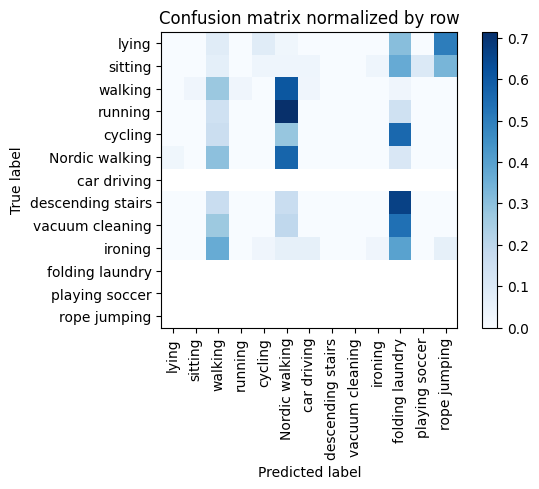

c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training Epoch:  20%|██        | 1/5 [00:10<00:41, 10.32s/it]

Overall accuracy: 0.123

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   Nordic walking       0.300      0.568      0.393      0.147         37|	 walking: 0.297,	folding laundry: 0.108,	
            lying       0.000      0.000      0.000      0.143         36|	 rope jumping: 0.500,	folding laundry: 0.306,	cycling: 0.083,	
          ironing       0.500      0.030      0.057      0.131         33|	 folding laundry: 0.394,	walking: 0.364,	rope jumping: 0.061,	
          walking       0.170      0.273      0.209      0.131         33|	 Nordic walking: 0.606,	folding laundry: 0.030,	
          sitting       0.000      0.000      0.000      0.119         30|	 folding laundry: 0.367,	rope jumping: 0.333,	playing soccer: 0.100,	
  vacuum cleaning       0.000      0.000      0.000      0.103         26|	 folding laundry: 0.538,	walking: 0.269,	Nordic walking: 0.192,	
          cycling       0.000      0.000      0.000      0.099         25|	 fold

eval: 100%|██████████| 8/8 [00:01<00:00,  6.11batch/s, loss=0.166]
g:\FYP\Codebases\HAR-ZSL-XAI\src\utils\analysis.py:121: RuntimeWarning: invalid value encountered in divide
  ConfMatrix_normalized_row = ConfMatrix.astype('float') / ConfMatrix.sum(axis=1)[:, np.newaxis] #@nipdep


(252,) (252,)


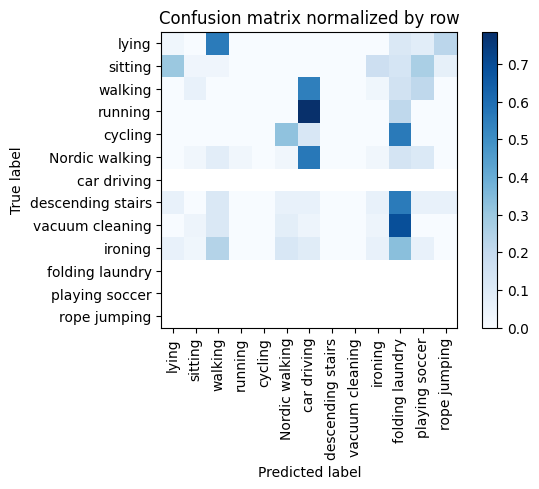

c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training Epoch:  40%|████      | 2/5 [00:21<00:33, 11.05s/it]

Overall accuracy: 0.020

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   Nordic walking       0.062      0.027      0.038      0.147         37|	 car driving: 0.568,	folding laundry: 0.135,	playing soccer: 0.108,	
            lying       0.077      0.028      0.041      0.143         36|	 walking: 0.556,	rope jumping: 0.222,	folding laundry: 0.111,	
          ironing       0.182      0.061      0.091      0.131         33|	 folding laundry: 0.333,	walking: 0.242,	Nordic walking: 0.121,	
          walking       0.000      0.000      0.000      0.131         33|	 car driving: 0.545,	playing soccer: 0.212,	folding laundry: 0.152,	
          sitting       0.167      0.033      0.056      0.119         30|	 lying: 0.300,	playing soccer: 0.267,	ironing: 0.167,	
  vacuum cleaning       0.000      0.000      0.000      0.103         26|	 folding laundry: 0.692,	walking: 0.115,	Nordic walking: 0.077,	
          cycling       0.000      0.000      

eval: 100%|██████████| 8/8 [00:00<00:00,  9.21batch/s, loss=0.136]
g:\FYP\Codebases\HAR-ZSL-XAI\src\utils\analysis.py:121: RuntimeWarning: invalid value encountered in divide
  ConfMatrix_normalized_row = ConfMatrix.astype('float') / ConfMatrix.sum(axis=1)[:, np.newaxis] #@nipdep


(252,) (252,)


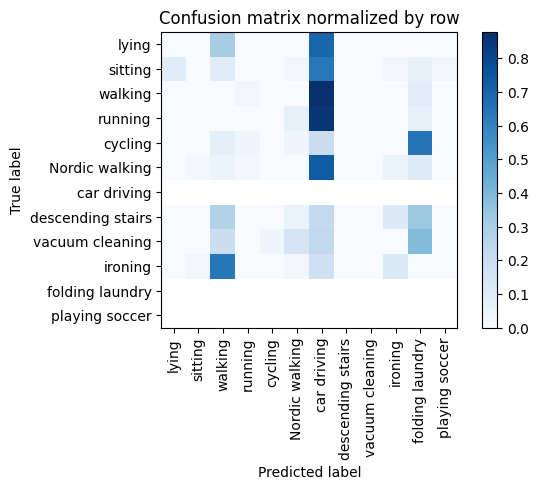

c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training Epoch:  60%|██████    | 3/5 [00:33<00:22, 11.25s/it]

Overall accuracy: 0.016

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   Nordic walking       0.000      0.000      0.000      0.147         37|	 car driving: 0.730,	folding laundry: 0.108,	ironing: 0.054,	
            lying       0.000      0.000      0.000      0.143         36|	 car driving: 0.694,	walking: 0.306,	playing soccer: 0.000,	
          ironing       0.444      0.121      0.190      0.131         33|	 walking: 0.636,	car driving: 0.182,	
          walking       0.000      0.000      0.000      0.131         33|	 car driving: 0.879,	folding laundry: 0.091,	running: 0.030,	
          sitting       0.000      0.000      0.000      0.119         30|	 car driving: 0.633,	walking: 0.100,	lying: 0.100,	
  vacuum cleaning       0.000      0.000      0.000      0.103         26|	 folding laundry: 0.385,	car driving: 0.231,	walking: 0.192,	
          cycling       0.000      0.000      0.000      0.099         25|	 folding laundry: 0.

eval: 100%|██████████| 8/8 [00:01<00:00,  7.38batch/s, loss=0.111]
g:\FYP\Codebases\HAR-ZSL-XAI\src\utils\analysis.py:121: RuntimeWarning: invalid value encountered in divide
  ConfMatrix_normalized_row = ConfMatrix.astype('float') / ConfMatrix.sum(axis=1)[:, np.newaxis] #@nipdep


(252,) (252,)


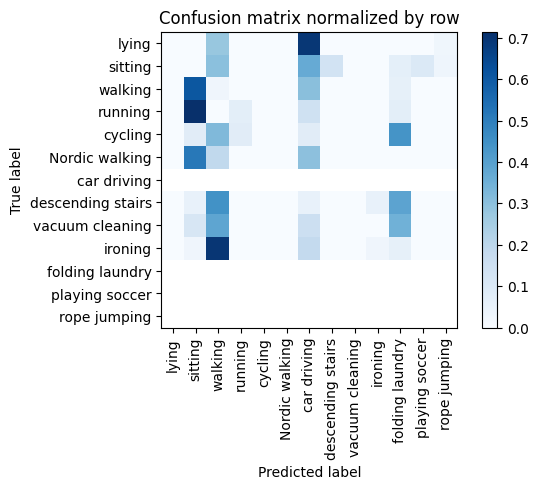

c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training Epoch:  80%|████████  | 4/5 [00:44<00:11, 11.04s/it]

Overall accuracy: 0.012

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   Nordic walking       0.000      0.000      0.000      0.147         37|	 sitting: 0.514,	car driving: 0.297,	walking: 0.189,	
            lying       0.000      0.000      0.000      0.143         36|	 car driving: 0.694,	walking: 0.278,	rope jumping: 0.028,	
          ironing       0.500      0.030      0.057      0.131         33|	 walking: 0.697,	car driving: 0.182,	folding laundry: 0.061,	
          walking       0.013      0.030      0.018      0.131         33|	 sitting: 0.606,	car driving: 0.303,	folding laundry: 0.061,	
          sitting       0.000      0.000      0.000      0.119         30|	 car driving: 0.367,	walking: 0.300,	descending stairs: 0.133,	
  vacuum cleaning       0.000      0.000      0.000      0.103         26|	 walking: 0.385,	folding laundry: 0.346,	car driving: 0.154,	
          cycling       0.000      0.000      0.000      0.099       

eval:  50%|█████     | 4/8 [00:00<00:00,  6.46batch/s, loss=0.134]


KeyboardInterrupt: 

In [9]:
for i, cs in enumerate(fold_cls_ids):
    # separate seen/unseen and train/eval 
    data_dict = dataReader.generate(unseen_classes=cs, resampling=True, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'])
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    train_n, seq_len, in_ft = data_dict['train']['X'].shape
    # build train_dt 
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build seen eval_dt 
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=unseen_classes)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    
    # build model
    model = ZSLHARNet(in_ft=in_ft, d_model=config['d_model'], num_heads=config['num_heads'], ft_size=feat_size, attr_size=attr_size, max_len=seq_len)
    model.to(device)
    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'])
    loss_module = {'feature': FeatureLoss(), 'attribute': AttributeLoss()}
    best_acc = 0.0
    # train the model 
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics = train_step(model, train_dl, optimizer, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes], target_feat_met=train_dt.target_feat, phase='train')
        eval_metrics = eval_step(model, eval_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes],  target_feat_met=train_dt.target_feat, phase='eval')
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['total_accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    if best_acc == 0.0:
        best_model = deepcopy(model.state_dict())
    
    # replace by best model 
    model.load_state_dict(best_model)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in unseen_classes],  target_feat_met=train_dt.target_feat, phase='eval')
    print(test_metrics)